In [1]:
import sys

from pymodulon.core import *
from pymodulon.plotting import *
from pymodulon.enrichment import *
from pymodulon.compare import *
from pymodulon.io import *

from Bio.KEGG import REST
import tqdm.notebook as tqdm

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib_venn import *
import seaborn as sns

from matplotlib.lines import Line2D


# Import Data and Create ICA_DATA Object

In [2]:
interim = "../data/interim/ica_runs/180/"
processed = "../data/processed_data/"

ica_data = IcaData(interim+"S.csv",interim+"A.csv", X=processed+"log_tpm_norm.csv",
                  sample_table=processed+"metadata_final.csv", trn = processed+"TRN.csv",
                   gene_table=processed+"gene_info.csv")


## Rename iModulons

In [3]:
comp_names = list(pd.read_csv(processed+"iModulon_names.csv",index_col=0).index)

rename = {}

for old,new in zip(range(0,80),comp_names):
    rename.update({old:new})

ica_data.rename_imodulons(rename)

ica_data.change_threshold("Central Carbon Metabolism",.05)
ica_data.change_threshold("Peptidoglycan Biosynthesis",.06)
ica_data.change_threshold("Lsr2",.05)


ica_data.A.head()

,SRX3995807,SRX3995806,SRX3995809,SRX3995808,SRX4619048,SRX4619047,SRX4619049,SRX4619050,SRX3995804,SRX3995805,...,SRX4498326,SRX4498328,SRX4498330,SRX4498336,SRX4498333,SRX4498338,SRX4498329,SRX4498325,SRX4498327,SRX4498331
SigH,2.233529,1.747683,1.950159,1.272614,2.236327,1.461665,1.721740,1.716646,0.199084,-0.199084,...,-0.073048,-0.089859,-0.056653,0.272666,0.561386,0.565625,0.928080,0.692540,0.989420,0.978320
Polyketide Synthase Complex,-1.006571,-1.096669,-1.035640,-1.020379,-1.284973,-1.032381,-0.228997,-0.436043,-0.339446,0.339446,...,-0.060317,0.071409,0.197522,4.220594,4.335245,4.791054,2.873865,3.053068,3.106209,2.544357
IniR,-1.633546,-1.525702,-0.973362,-0.412119,-1.575615,-0.661602,-0.413391,-1.286532,-0.227573,0.227573,...,-0.082660,-0.249290,0.542238,-1.337300,-1.332386,-0.657241,-1.025463,-0.751884,-0.543233,-0.929784
PyrR,0.724746,0.685656,0.463208,0.779347,0.891500,0.706596,1.367180,1.396856,0.426180,-0.426180,...,0.094624,0.297912,-0.241379,1.186755,0.660442,0.640216,1.951114,2.235133,2.241501,1.747601
WhiB4,-0.187071,0.778767,-0.132223,0.820021,0.097570,1.035989,1.112930,0.707870,0.450103,-0.450103,...,-0.196057,-0.186073,0.212741,1.362617,1.387968,1.945811,1.459615,2.011044,1.298987,1.454773


# Virulence Plots

## 1D DIMA Plot

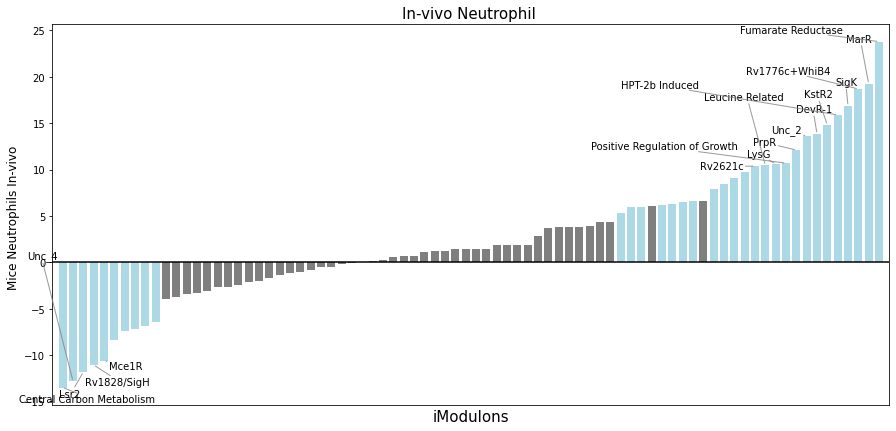

In [9]:
from adjustText import adjust_text
from pymodulon.util import dima

base_condition = "miceNF:control"
diff_condition = "miceNF:invivo"
threshold = 5

table = dima(ica_data,base_condition,diff_condition,threshold=threshold)

fig,ax = plt.subplots(figsize=[15,7])
dima_samples = ica_data.sample_table.loc[ica_data.sample_table["full_name"]==diff_condition].index
activity_data = (ica_data.A[dima_samples].mean(axis=1)).sort_values()

labels=[]
width = 0
bars = plt.bar(activity_data.index,activity_data)

# You can use this section to control which labels you want to display. Just add an additional if/else statement
# to filter out any labels that don't meet a certain criteria (Ex. Only put labels on activity greater than 10,
# but still color all points with activity greater than 5)
for i in range(0,len(activity_data)):
    if activity_data.index[i] in table.index:
        if "SG" in activity_data.index[i]:
            ax.bar(activity_data.index[i],activity_data[i],color="tab:grey")
        elif abs(activity_data[i]) < 10:
            ax.bar(activity_data.index[i],activity_data[i],color="lightblue")
        else:
            ax.bar(activity_data.index[i],activity_data[i],color="lightblue")
            labels.append(ax.text(width, activity_data[i],
                                  activity_data.index[i],fontsize=10))
    else:
        ax.bar(activity_data.index[i],activity_data[i],color="tab:gray")
    width+=1

adjust_text(labels,ax=ax, add_objects= bars, 
            arrowprops=dict(arrowstyle="-",color="gray",lw=1,alpha=.8,zorder=0))

ax.plot([-1,80],[0,0],color="black")
ax.set_xlim([-1,80])
ax.set_xlabel("iModulons",fontsize=15)
ax.set_ylabel("Mice Neutrophils In-vivo ",fontsize=12)
ax.set_title("In-vivo Neutrophil ",fontsize=15)
    
plt.xticks([])
plt.savefig("../figures/interim_figures/Neutrophil_DIMA.svg",transparent=True)

## Virulence Venn Diagram

In [5]:
table1 = dima(ica_data,"miceBMDM:inf02","miceBMDM:no_inf02")
table2 = dima(ica_data,"miceBMDM:inf08","miceBMDM:no_inf08")
table3 = dima(ica_data,"miceBMDM:inf24","miceBMDM:no_inf24")

In [6]:
table = dima(ica_data,"miceNF:control","miceNF:invivo")

<AxesSubplot:>

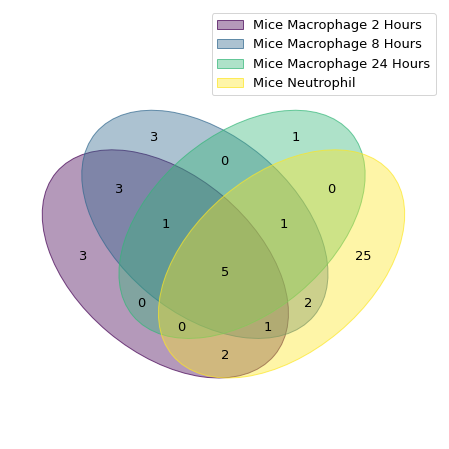

In [7]:
from venn import venn
data = {"Mice Macrophage 2 Hours":set(table1.index),
        "Mice Macrophage 8 Hours":set(table2.index),
        "Mice Macrophage 24 Hours":set(table3.index),
        "Mice Neutrophil":set(table.index)}
venn(data)
plot.save_fig("../figures/interim_figures/Virulence_Venn.svg",transparent = True)